This tutorial goes over how to run the flexvalue library in order to calculate avoided costs for electricity and gas. This library uses a cleaned up version of the CPUC Cost Effectiveness Calculator, which has been reformatted into a SQLite file.

Before calculating results, you must first download this SQLite file. It is currently being hosted publically at `https://storage.googleapis.com/flexvalue-public-resources/{year}.db`. At the time of this writing, the most current avoided costs data available is for [2020](https://storage.googleapis.com/flexvalue-public-resources/2020.db).

By default, this SQLite file will be saved in the `flexvalue`. Since this notebook is stored in `flexvalue/notebooks`, to maintain consistency we need to adjust the database location. You can do this through an environment variable.

In [1]:
import os
# to ensure this gets saved at flexvalue/db, since this notebook is executed in flexvalue/notebooks
try:
    import google.colab
except:
    if not os.environ.get('DATABASE_LOCATION_ORIG'):
        os.environ["DATABASE_LOCATION_ORIG"] = os.environ.get('DATABASE_LOCATION', '.')
    os.environ["DATABASE_LOCATION"] = '../' + os.environ['DATABASE_LOCATION_ORIG'] 

In [2]:
# uncomment the line below if you are running on colab
#!pip install flexvalue 

You can download the SQLite file through a CLI command. By default, each time you run the command, it will download and overwrite the file for that year. However, there is a `--skip-if-exists` parameter which will first check if that years data has already been downloaded before attempting to download. The 2020 SQLite file is ~2 GB.

For the purposes of this tutorial, we will use the 2020 avoided costs data.

In [3]:
# This command can be run from the CLI. It will download the sqlite db that contains the avoided costs for electricity and gas and the deer load shape.
!flexvalue download-avoided-costs-data-db --skip-if-exists --year 2020

# Avoided Costs Database

This database contains 3 tables: `deer_ls`, `avoided_costs_elec`, `avoided_costs_gas`.

In [4]:
import pandas as pd
import sqlite3
db_filepath = os.path.join(os.environ['DATABASE_LOCATION'], "2020.db")
con = sqlite3.connect(db_filepath)

## deer_load_shapes

The DEER load shapes are normalized 8,760 hourly savings profiles that correspond to different end-use sectors and technologies (residential HVAC or commercial lighting for example). A full list is provided in reference . Annual deemed kWh savings values are typically assigned to a specific DEER load shape. The resulting 8,760 hourly savings values are then multiplied by the hourly electric avoided costs to produce the electric cost effectiveness benefits. 

__*Additional ETL*__

Recurve has made a few changes to column names to incorporate residential and commercial naming conventions but otherwise the format of the DEER load shapes does not need to be updated. Additional ETL is needed because the electric avoided costs begin on a day of the week that does not align with the DEER load shapes. Recurve has conducted extensive testing and has found that the DEER load shapes need to be shifted by -2 days in order to provide the best alignment with the CPUC’s existing Cost Effectiveness Tool.

__*Notes*__

There are different versions of the DEER load shape files for each of the four California IOUs. At this point Recurve have not explicitly tested these different versions to gauge any differences. Recurve is currently using  the PG&E version. This database may need to be updated to incorporate each version of the DEER load shapes. It is also not known at this point if a different shift will need to be incorporated upon release of the next electric avoided cost calculator.


In [5]:
df_deer_load_shapes = pd.read_sql("select * from deer_load_shapes", con=con).drop("local_pkid_", axis=1)
df_deer_load_shapes

,hour_of_year,RES_INDOOR_CFL_LTG,RES_REFGFRZR_HIGHEFF,RES_REFGFRZR_RECYC_CONDITIONED,RES_REFGFRZR_RECYC_UNCONDITIONED,RES_HVAC_EFF_AC,RES_HVAC_EFF_HP,RES_HVAC_DUCT_SEALING,RES_HVAC_REFRIG_CHARGE,RES_REFG_CHRG_DUCT_SEAL,RES_REFGFRZR_RECYCLING,NONRES_INDOOR_CFL_LTG,NONRES_INDOOR_NON_CFL_LTG,NONRES_HVAC_CHILLERS,NONRES_HVAC_REFRIG_CHARGE,NONRES_HVAC_SPLIT_PACKAGE_AC,NONRES_HVAC_DUCT_SEALING,NONRES_HVAC_SPLIT_PACKAGE_HP,RES_CLOTHESDISHWASHER,RES_BLDGSHELL_INS
0,0,0.000082,0.000082,0.000082,0.000066,0.000084,0.000343,0.000066,4.190000e-07,0.000056,0.000074,0.000051,0.000028,0.000002,-2.290000e-09,0.000013,-0.000019,0.000023,0.000034,0.000206
1,24,0.000081,0.000082,0.000082,0.000067,0.000081,0.000330,0.000071,4.690000e-07,0.000053,0.000074,0.000050,0.000028,0.000002,-9.140000e-10,0.000014,-0.000015,0.000024,0.000034,0.000212
2,48,0.000065,0.000082,0.000082,0.000055,0.000095,0.000321,0.000077,6.500000e-07,0.000057,0.000068,0.000041,0.000023,0.000001,-2.350000e-09,0.000014,-0.000010,0.000031,0.000033,0.000227
3,72,0.000064,0.000081,0.000081,0.000068,0.000086,0.000309,0.000079,7.820000e-07,0.000057,0.000074,0.000035,0.000023,0.000001,-1.610000e-08,0.000013,-0.000016,0.000027,0.000033,0.000219
4,96,0.000082,0.000082,0.000082,0.000057,0.000082,0.000285,0.000068,1.010000e-06,0.000061,0.000070,0.000051,0.000028,0.000002,-2.130000e-08,0.000014,-0.000018,0.000031,0.000034,0.000200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8663,0.000119,0.000084,0.000084,0.000064,0.000077,0.000315,0.000058,4.080000e-07,0.000058,0.000074,0.000037,0.000025,0.000003,-1.380000e-08,0.000015,-0.000022,0.000033,0.000058,0.000197
8756,8687,0.000130,0.000085,0.000085,0.000054,0.000064,0.000292,0.000061,1.440000e-06,0.000068,0.000069,0.000056,0.000034,0.000003,-4.470000e-10,0.000014,-0.000012,0.000028,0.000058,0.000203
8757,8711,0.000131,0.000085,0.000085,0.000063,0.000067,0.000316,0.000058,1.300000e-06,0.000061,0.000074,0.000057,0.000034,0.000003,-2.490000e-09,0.000015,-0.000022,0.000025,0.000058,0.000191
8758,8735,0.000118,0.000084,0.000084,0.000067,0.000066,0.000325,0.000059,6.990000e-07,0.000052,0.000076,0.000036,0.000024,0.000003,-7.040000e-09,0.000018,-0.000046,0.000042,0.000058,0.000204


In [6]:
deer_load_shapes_available = pd.read_sql(
    """
    SELECT *
    FROM deer_load_shapes
    limit 1
    """, con=con
)
list(deer_load_shapes_available.drop('hour_of_year', axis=1).columns)

['RES_INDOOR_CFL_LTG',
 'RES_REFGFRZR_HIGHEFF',
 'RES_REFGFRZR_RECYC_CONDITIONED',
 'RES_REFGFRZR_RECYC_UNCONDITIONED',
 'RES_HVAC_EFF_AC',
 'RES_HVAC_EFF_HP',
 'RES_HVAC_DUCT_SEALING',
 'RES_HVAC_REFRIG_CHARGE',
 'RES_REFG_CHRG_DUCT_SEAL',
 'RES_REFGFRZR_RECYCLING',
 'NONRES_INDOOR_CFL_LTG',
 'NONRES_INDOOR_NON_CFL_LTG',
 'NONRES_HVAC_CHILLERS',
 'NONRES_HVAC_REFRIG_CHARGE',
 'NONRES_HVAC_SPLIT_PACKAGE_AC',
 'NONRES_HVAC_DUCT_SEALING',
 'NONRES_HVAC_SPLIT_PACKAGE_HP',
 'RES_CLOTHESDISHWASHER',
 'RES_BLDGSHELL_INS',
 'local_pkid_']

There is a helper command if you want this list directly in python

In [7]:
from flexvalue import get_all_valid_deer_load_shapes
get_all_valid_deer_load_shapes(database_year='2020')

['RES_INDOOR_CFL_LTG',
 'RES_REFGFRZR_HIGHEFF',
 'RES_REFGFRZR_RECYC_CONDITIONED',
 'RES_REFGFRZR_RECYC_UNCONDITIONED',
 'RES_HVAC_EFF_AC',
 'RES_HVAC_EFF_HP',
 'RES_HVAC_DUCT_SEALING',
 'RES_HVAC_REFRIG_CHARGE',
 'RES_REFG_CHRG_DUCT_SEAL',
 'RES_REFGFRZR_RECYCLING',
 'NONRES_INDOOR_CFL_LTG',
 'NONRES_INDOOR_NON_CFL_LTG',
 'NONRES_HVAC_CHILLERS',
 'NONRES_HVAC_REFRIG_CHARGE',
 'NONRES_HVAC_SPLIT_PACKAGE_AC',
 'NONRES_HVAC_DUCT_SEALING',
 'NONRES_HVAC_SPLIT_PACKAGE_HP',
 'RES_CLOTHESDISHWASHER',
 'RES_BLDGSHELL_INS']

## acc_electricity

The electric avoided cost calculator compiles hourly marginal utility avoided costs for electric savings. Costs are provided for ten different components and are projected forward through 2050. Avoided costs are distinct for each utility service territory (PG&E, SCE, SDG&E, and SoCalGas) and Climate Zone combination. The electric avoided cost calculator also contains hourly marginal greenhouse gas emissions data, which are also forecasted to 2050. 

The electric avoided cost calculator can be downloaded as a .xlsb file from [here](https://www.cpuc.ca.gov/General.aspx?id=5267).

The electric avoided cost calculator is a macro-driven Excel file, so several ETL steps were done to combine all calculator results into a single table.

In [8]:
df_avoided_costs_electricity = pd.read_sql("select * from acc_electricity limit 5", con=con)
df_avoided_costs_electricity

,utility,climate_zone,datetime,year,month,hour_of_day,hour_of_year,total,energy,losses,...,capacity,transmission,distribution,cap_and_trade,ghg_adder,ghg_rebalancing,methane_leakage,marginal_ghg,ghg_adder_rebalancing,local_pkid_
0,SCE,CZ14,2030-07-27 07:00:00 UTC,2030,7,7,4975,119.059012,45.383113,3.285737,...,0.0,0.00000,6.471175,31.413516,47.242566,-24.250364,8.727548,0.251067,22.992202,013e22c128bdf11eb9b410242ac140002
1,SCE,CZ14,2030-07-27 15:00:00 UTC,2030,7,15,4983,286.330149,119.145551,8.626138,...,0.0,0.00000,26.246724,54.512594,81.981105,-24.250364,18.005627,0.517970,57.730741,113e22c128bdf11eb9b410242ac140002
2,SCE,CZ14,2030-07-27 22:00:00 UTC,2030,7,22,4990,121.740441,48.310949,3.497713,...,0.0,0.00000,0.000143,33.465433,50.328428,-24.250364,9.551730,0.274776,26.078064,213e22c128bdf11eb9b410242ac140002
3,SCE,CZ14,2030-08-07 16:00:00 UTC,2030,8,16,5248,1079.414557,112.717593,8.160754,...,0.0,816.22002,19.504031,51.281444,77.121803,-24.250364,16.707789,0.480635,52.871439,313e22c128bdf11eb9b410242ac140002
4,SCE,CZ14,2030-09-02 12:00:00 UTC,2030,9,12,5868,116.674556,44.841843,3.246549,...,0.0,0.00000,0.000000,33.023035,49.663109,-24.250364,9.374034,0.269664,25.412745,413e22c128bdf11eb9b410242ac140002


The following are all of the unique utility/climate zone combinations available in the calculator

In [9]:
utility_climate_zone_combinations = pd.read_sql(
    """
    SELECT utility, climate_zone
    FROM acc_electricity
    GROUP BY utility, climate_zone
    ORDER BY utility, climate_zone
    """, con=con
)
utility_climate_zone_combinations

,utility,climate_zone
0,PGE,CZ1
1,PGE,CZ11
2,PGE,CZ12
3,PGE,CZ13
4,PGE,CZ16
5,PGE,CZ2
6,PGE,CZ3A
7,PGE,CZ3B
8,PGE,CZ4
9,PGE,CZ5


There is a helper command if you want this list directly in python

In [10]:
from flexvalue import get_all_valid_utility_climate_zone_combinations
get_all_valid_utility_climate_zone_combinations(database_year='2020')

,utility,climate_zone
0,PGE,CZ1
1,PGE,CZ11
2,PGE,CZ12
3,PGE,CZ13
4,PGE,CZ16
5,PGE,CZ2
6,PGE,CZ3A
7,PGE,CZ3B
8,PGE,CZ4
9,PGE,CZ5


In [11]:
get_all_valid_utility_climate_zone_combinations(database_year='2020', utility='SDGE')

,utility,climate_zone
0,SDGE,CZ10
1,SDGE,CZ14
2,SDGE,CZ15
3,SDGE,CZ7


## acc_gas

The gas avoided cost calculator compiles monthly marginal utility avoided costs for gas savings. Costs are provided for four different components and are projected forward through 2050. Avoided costs are distinct for each utility service territory (PG&E, SCE, SDG&E, and SoCalGas). Avoided costs are also somewhat different for distinct end use categories. 

The gas avoided cost calculator can be downloaded as a .xlsb file from [here](https://www.cpuc.ca.gov/General.aspx?id=5267).

The gas avoided cost calculator is a macro-driven Excel file, so several ETL steps were done to combine all calculator results into a single table.

In [12]:
df_avoided_costs_gas = pd.read_sql("select * from acc_gas limit 10", con=con)
df_avoided_costs_gas

,year,month,market,t_d,environment,upstream_methane,total,btm_methane,local_pkid_
0,2020,1,0.270297,0.338191,0.610998,0.022285,1.241770,0.015123,0768ee9228bdf11eb9b410242ac140002
1,2020,2,0.232967,0.338191,0.610998,0.022285,1.204440,0.015123,1768ee9228bdf11eb9b410242ac140002
2,2020,3,0.214088,0.338191,0.610998,0.022285,1.185562,0.015123,2768ee9228bdf11eb9b410242ac140002
3,2020,4,0.190713,0.000000,0.610998,0.022285,0.823995,0.015123,3768ee9228bdf11eb9b410242ac140002
4,2020,5,0.195206,0.000000,0.610998,0.022285,0.828489,0.015123,4768ee9228bdf11eb9b410242ac140002
5,2020,6,0.238072,0.000000,0.610998,0.022285,0.871354,0.015123,5768ee9228bdf11eb9b410242ac140002
6,2020,7,0.260448,0.000000,0.610998,0.022285,0.893731,0.015123,6768ee9228bdf11eb9b410242ac140002
7,2020,8,0.250158,0.000000,0.610998,0.022285,0.883440,0.015123,7768ee9228bdf11eb9b410242ac140002
8,2020,9,0.238864,0.000000,0.610998,0.022285,0.872147,0.015123,8768ee9228bdf11eb9b410242ac140002
9,2020,10,0.261744,0.000000,0.610998,0.022285,0.895026,0.015123,9768ee9228bdf11eb9b410242ac140002


# Inputs to FlexValue

*user_inputs_file*: A file that is one row per meter that contains all of the parameters necessary to calculate avoided costs for that meter. The load_shape column in this table corresponds either with a DEER load shape or a column name in the metered_load_shape_file.
*NOTE: If using the user_inputs in python, the code expects it to be indexed on `ID`.

*metered_load_shape_file*: A file that is one row per hour of year, with each column being a unique identifier. 
*NOTE: If using the metered_load_shape in python, the code expects it to be indexed on `hour_of_year`.*

For the purposes of testing, we provide some example files that can be used. They can be created into CSVs for CLI command usage using a special CLI command. In this case, the files will be saved to the `flexvalue/test_data` folder.
```
flexvalue generate-example-inputs
```

The inputs can also be directly called in python using the following code. 
```
from flexvalue.examples import get_example_user_inputs_deer, get_example_user_inputs_metered, get_example_metered_load_shape
user_inputs_deer = get_example_user_inputs_deer()
user_inputs_metered = get_example_user_inputs_metered()
metered_load_shape = get_example_metered_load_shape()
```

In [13]:
!flexvalue generate-example-inputs --output-filepath ../test_data

In [14]:
os.listdir('../test_data')

['example_user_inputs_deer.csv',
 'example_user_inputs_metered.csv',
 'example_metered_load_shape.csv']

In [15]:
from flexvalue.examples import get_example_user_inputs_deer, get_example_user_inputs_metered, get_example_metered_load_shape

In [16]:
metered_load_shape = pd.read_csv('../test_data/example_metered_load_shape.csv', index_col='hour_of_year')
# or
metered_load_shape = get_example_metered_load_shape()

In [17]:
user_inputs_deer = pd.read_csv('../test_data/example_user_inputs_deer.csv')
# or
user_inputs_deer = get_example_user_inputs_deer(database_year='2020')

In [18]:
user_inputs_metered = pd.read_csv('../test_data/example_user_inputs_metered.csv')
# or
user_inputs_metered = get_example_user_inputs_metered(metered_load_shape.columns)

In [19]:
pd.concat([user_inputs_metered, user_inputs_deer])

,load_shape,start_year,start_quarter,utility,climate_zone,units,eul,ntg,discount_rate,admin,measure,incentive,therms_profile,therms_savings,mwh_savings
ID,,,,,,,,,,,,,,,
heat_pump_impact1,heat_pump_impact1,2021,1,PGE,CZ12,1,15,1.00,0.0766,100,2000,1000,winter,400,1
deer_id_0,RES_INDOOR_CFL_LTG,2020,1,PGE,CZ3A,1,9,0.95,0.0766,10000,2000,3000,annual,100,1000
deer_id_1,RES_REFGFRZR_HIGHEFF,2020,2,PGE,CZ3A,1,9,0.95,0.0766,20000,4000,6000,annual,200,2000
deer_id_2,RES_REFGFRZR_RECYC_CONDITIONED,2020,3,PGE,CZ3A,1,9,0.95,0.0766,30000,6000,9000,annual,300,3000
deer_id_3,RES_REFGFRZR_RECYC_UNCONDITIONED,2020,4,PGE,CZ3A,1,9,0.95,0.0766,40000,8000,12000,annual,400,4000
deer_id_4,RES_HVAC_EFF_AC,2020,1,PGE,CZ3A,1,9,0.95,0.0766,50000,10000,15000,annual,500,5000


- **ID**: A unique identifier used to reference this measure, project, or portfolio
- **load_shape**: the name of the load shape to use (either referencing a column in the `metered_load_shape` file or an available DEER load shape)
- **start_year**: The year to start with when using avoided costs data
- **start_quarter**: The quarter to start with when using avoided costs data
- **utility**: Which uility to filter by when loading avoided costs data
- **climate_zone**: Which climate zone to filter by when loading avoided costs data
- **units**: Multiplier of the therms_savings and mwh_savings
- **eul**: Effective Useful Life (EUL) means the average time over which an energy efficiency measure results in energy savings, including the effects of equipment failure, removal, and cessation of use.
- **ntg**: Net to gross ratio
- **discount_rate**: The quarterly discount rate to be applied to the net present value calculation
- **admin**: The administrative costs assigned to a given measure, project, or portfolio
- **measure**: The measure costs assigned to given measure, project, or portfolio
- **inecentive**: The incentive costs assigned to given measure, project, or portfolio
- **therms_profile**: Indicates what sort of adjustment to make on the therms savings, can be one of ['annual', 'summer', 'winter']
- **therms_savings**: The first year gas gross savings in Therms
- **mwh_savings**: The first year electricity gross savings in MWh

*Note: Because the DEER load shapes are normalized, if a DEER load shape is used the* `mhw_savings` *entry should be the annual electricity savings for that element. If a metered or custom load shape is used, the* `mhw_savings` *should be set to the annual electricity savings if the load shape is normalized or set to 1 if the load shape has the intended absolute savings values.*


# Using the Library

There are two ways to run this library: 1) through the CLI, 2) using a python object.

## CLI

The cli command to run if only DEER load shapes are being used is:
```
flexvalue get-results --user-inputs-filepath {user_inputs_filepath}
```

The cli command to run if you also want to supply metered load shapes:
```
flexvalue get-results --user-inputs-filepath {user_inputs_filepath} --metered-load-shape-filepath {metered_load_shape_filepath} 
```

By default, the CLI command generates an HTML report containing many key plots. Use the `flexvalue get-results --help` command to get descriptions for the different inputs.

In [20]:
!flexvalue get-results --help

Usage: flexvalue get-results [OPTIONS]

  Calculates results and optionally writes a report

Options:
  --user-inputs-filepath TEXT     Filepath to the user-inputs CSV file that is
                                  used to calculate results  [required]

  --metered-load-shape-filepath TEXT
                                  Optional filepath to the CSV file containing
                                  metered load shapes

  --include-report / --exclude-report
                                  Whether to include an HTML report in the
                                  outputs  [default: True]

  --report-filepath TEXT          Filepath to where the report will be saved
                                  [default: report.html]

  --outputs-table-filepath TEXT   Filepath to where the outputs table CSV will
                                  be saved  [default: outputs_table.csv]

  -y, --year TEXT                 What year of the avoided costs data to use
                                  in 

In [21]:
!flexvalue get-results --user-inputs-filepath ../test_data/example_user_inputs_deer.csv --report-filepath reports/example_report_deer.html

In [22]:
!flexvalue get-results \
--user-inputs-filepath ../test_data/example_user_inputs_metered.csv  \
--metered-load-shape-filepath ../test_data/example_metered_load_shape.csv \
--report-filepath reports/example_report_metered.html

## Python

If using this library in python, you should know about the a key class that all code execution is built from.

The primary class is called `FlexValueRun`. This represents a single "run" of the flexvlaue library. To initialize this object, you need to pass in a `database_year` parameter, which indicates which year to use. This field is simply looking for a sqlite file in `flexvalue/db/{year}.db`.

You also can pass a metered_load_shape dataframe, indexed on `hour_of_year`. If you are only looking for DEER results, you don't need to pass this parameter.

In [23]:
from flexvalue import FlexValueRun

In [24]:
user_inputs_deer

,load_shape,start_year,start_quarter,utility,climate_zone,units,eul,ntg,discount_rate,admin,measure,incentive,therms_profile,therms_savings,mwh_savings
ID,,,,,,,,,,,,,,,
deer_id_0,RES_INDOOR_CFL_LTG,2020,1,PGE,CZ3A,1,9,0.95,0.0766,10000,2000,3000,annual,100,1000
deer_id_1,RES_REFGFRZR_HIGHEFF,2020,2,PGE,CZ3A,1,9,0.95,0.0766,20000,4000,6000,annual,200,2000
deer_id_2,RES_REFGFRZR_RECYC_CONDITIONED,2020,3,PGE,CZ3A,1,9,0.95,0.0766,30000,6000,9000,annual,300,3000
deer_id_3,RES_REFGFRZR_RECYC_UNCONDITIONED,2020,4,PGE,CZ3A,1,9,0.95,0.0766,40000,8000,12000,annual,400,4000
deer_id_4,RES_HVAC_EFF_AC,2020,1,PGE,CZ3A,1,9,0.95,0.0766,50000,10000,15000,annual,500,5000


In [25]:
# Running with the ids that are associated with DEER load shapes
from flexvalue.examples import get_example_user_inputs_deer
flx_run = FlexValueRun(database_year='2020')
user_inputs_deer = get_example_user_inputs_deer(database_year='2020')
outputs_table_deer, outputs_table_totals_deer, electric_benefits_deer, gas_benefits_deer = flx_run.get_results(user_inputs=user_inputs_deer)
outputs_table_deer

,ID,load_shape,start_year,start_quarter,utility,climate_zone,units,eul,ntg,discount_rate,...,TRC (and PAC) Total Benefits ($),TRC Costs ($),PAC Costs ($),Electricity First Year Net Savings (MWh),Electricity Lifecycle Net Savings (MWh),Gas First Year Net Savings (Therms),Gas Lifecycle Net Savings (Therms),Electricity Lifecycle GHG Savings (Tons),Gas Lifecycle GHG Savings (Tons),Total Lifecycle GHG Savings (Tons)
0,deer_id_0,RES_INDOOR_CFL_LTG,2020,1,PGE,CZ3A,1.0,9,0.95,0.0766,...,801098.81,12011.48,12943.63,950.000,8549.999,95.0,855.0,2515.340,5.13,2520.470
1,deer_id_1,RES_REFGFRZR_HIGHEFF,2020,2,PGE,CZ3A,1.0,9,0.95,0.0766,...,1450839.75,24022.96,25887.26,1900.004,17100.040,190.0,1710.0,4710.442,10.26,4720.702
2,deer_id_2,RES_REFGFRZR_RECYC_CONDITIONED,2020,3,PGE,CZ3A,1.0,9,0.95,0.0766,...,2225004.88,36034.44,38830.89,2850.007,25650.060,285.0,2565.0,7106.258,15.39,7121.648
3,deer_id_3,RES_REFGFRZR_RECYC_UNCONDITIONED,2020,4,PGE,CZ3A,1.0,9,0.95,0.0766,...,2950538.11,48045.92,51774.52,3800.117,34201.053,380.0,3420.0,9510.744,20.52,9531.264
4,deer_id_4,RES_HVAC_EFF_AC,2020,1,PGE,CZ3A,1.0,9,0.95,0.0766,...,4713548.12,60057.40,64718.15,4749.875,42748.879,475.0,4275.0,13208.215,25.65,13233.865


In [26]:
# Running with the ids that are associated with metered load shapes
from flexvalue.examples import get_example_user_inputs_metered, get_example_metered_load_shape
metered_load_shape = get_example_metered_load_shape()
flx_run = FlexValueRun(database_year='2020', metered_load_shape=metered_load_shape)
user_inputs_metered = get_example_user_inputs_metered(metered_load_shape.columns)
outputs_table_metered, outputs_table_totals_metered, electric_benefits_metered, gas_benefits_metered = flx_run.get_results(user_inputs=user_inputs_metered)
outputs_table_metered

,ID,load_shape,start_year,start_quarter,utility,climate_zone,units,eul,ntg,discount_rate,...,TRC (and PAC) Total Benefits ($),TRC Costs ($),PAC Costs ($),Electricity First Year Net Savings (MWh),Electricity Lifecycle Net Savings (MWh),Gas First Year Net Savings (Therms),Gas Lifecycle Net Savings (Therms),Electricity Lifecycle GHG Savings (Tons),Gas Lifecycle GHG Savings (Tons),Total Lifecycle GHG Savings (Tons)
0,heat_pump_impact1,heat_pump_impact1,2021,1,PGE,CZ12,1.0,15,1.0,0.0766,...,5084.78,2062.42,1081.21,-0.932,-13.984,400.0,6000.0,-4.935,36.0,31.065


# Reports

If you use the CLI command, an HTML report will be generated unless you use the `--exclude-report` parameter. In python, you can generate the plots that go into that report using the `plot_results(..)` function.

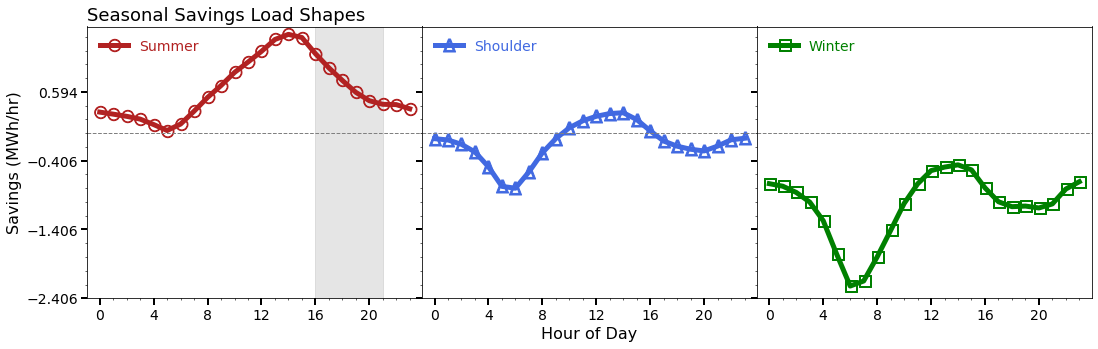

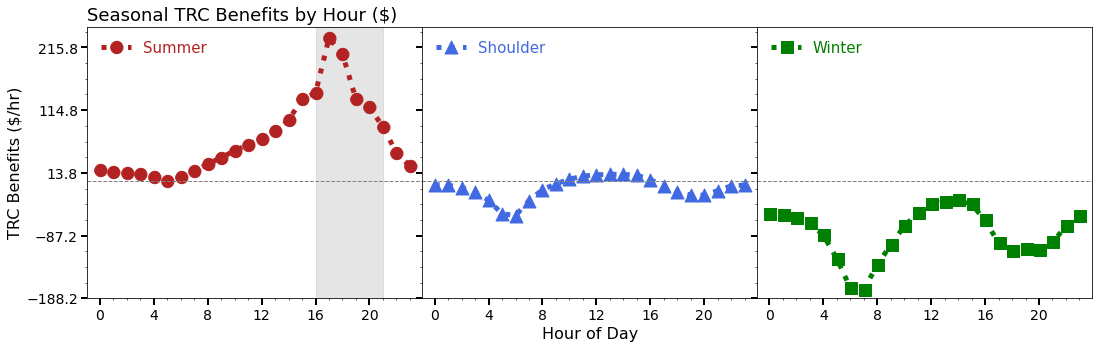

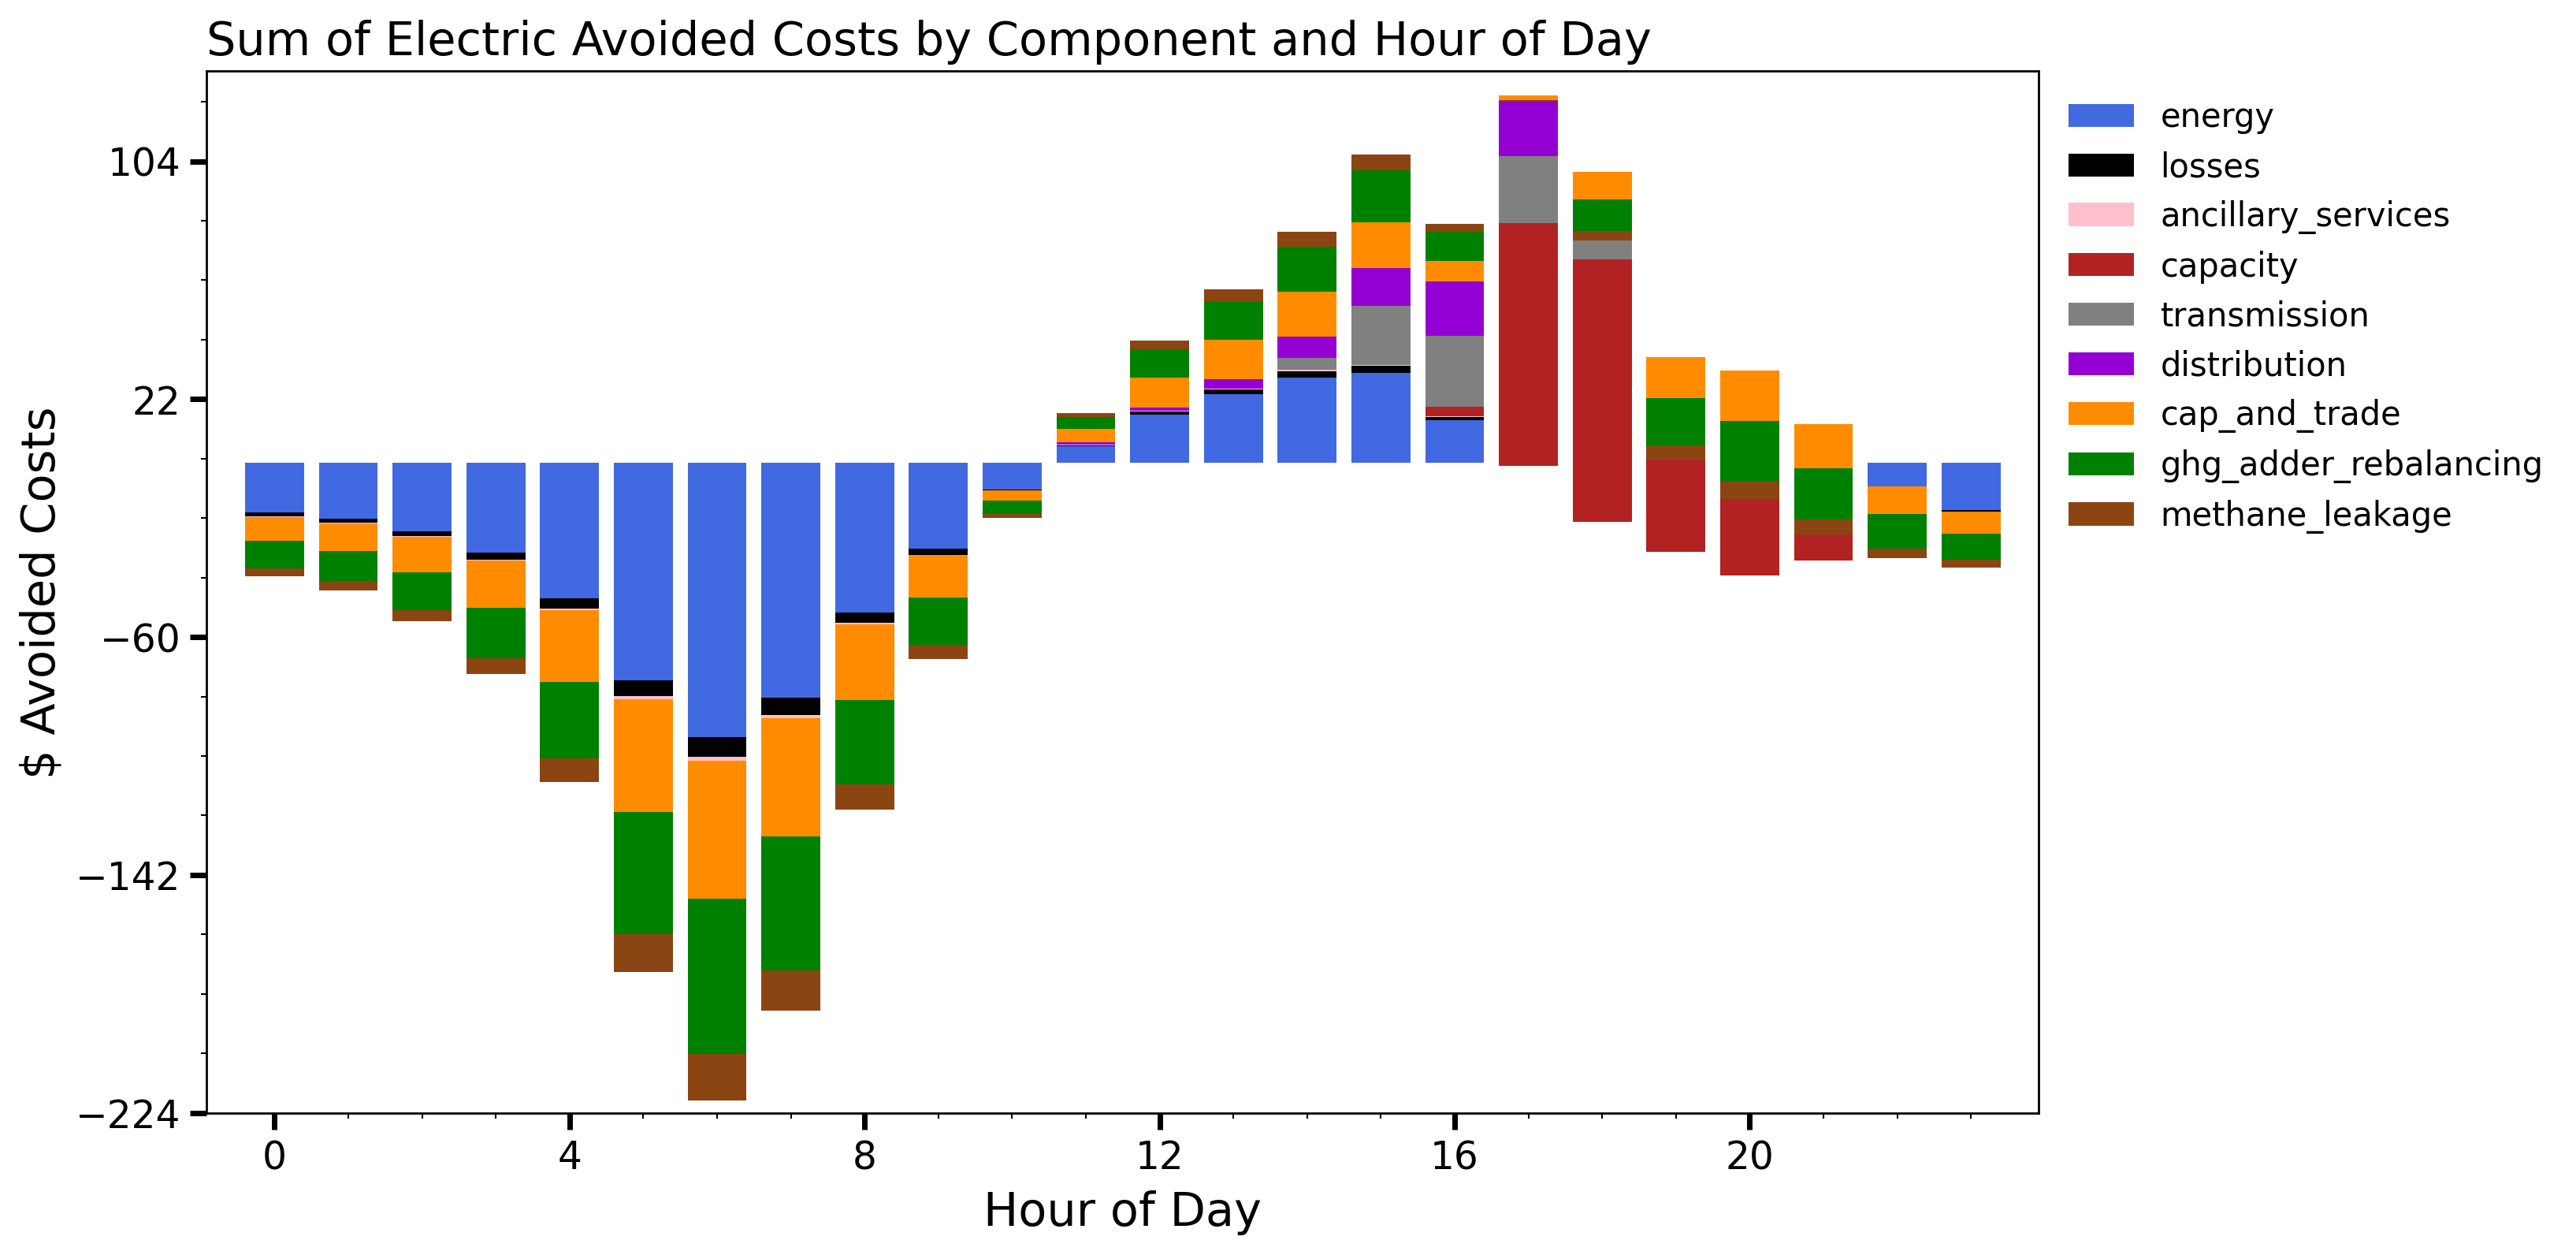

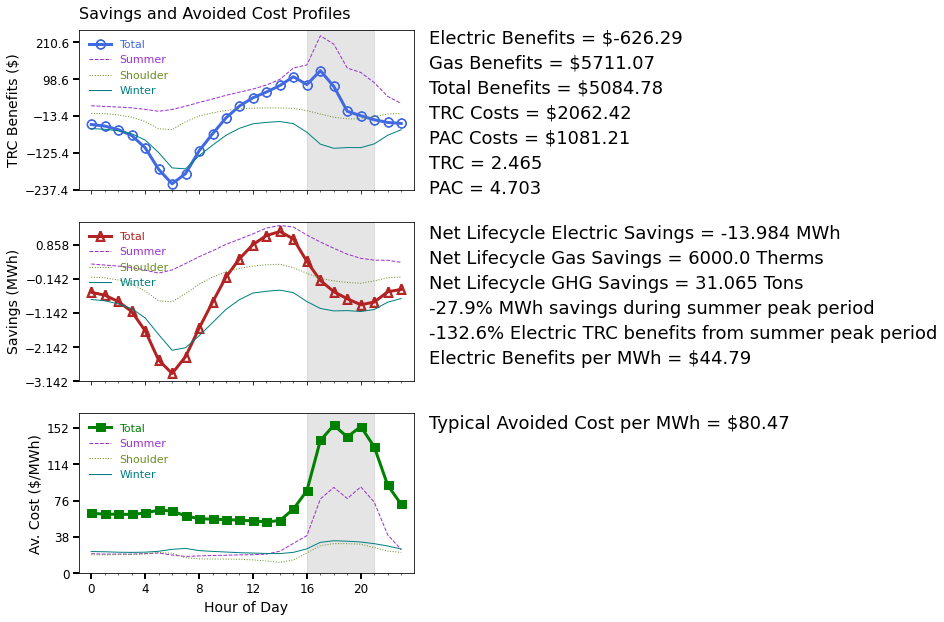

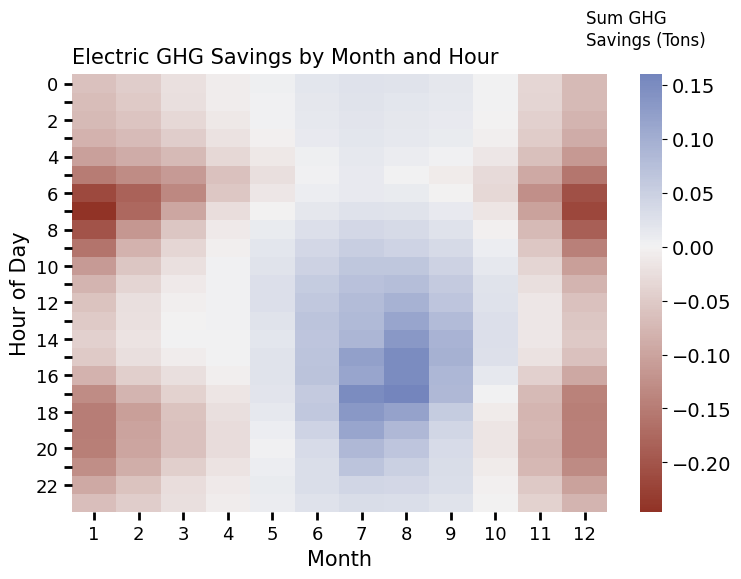

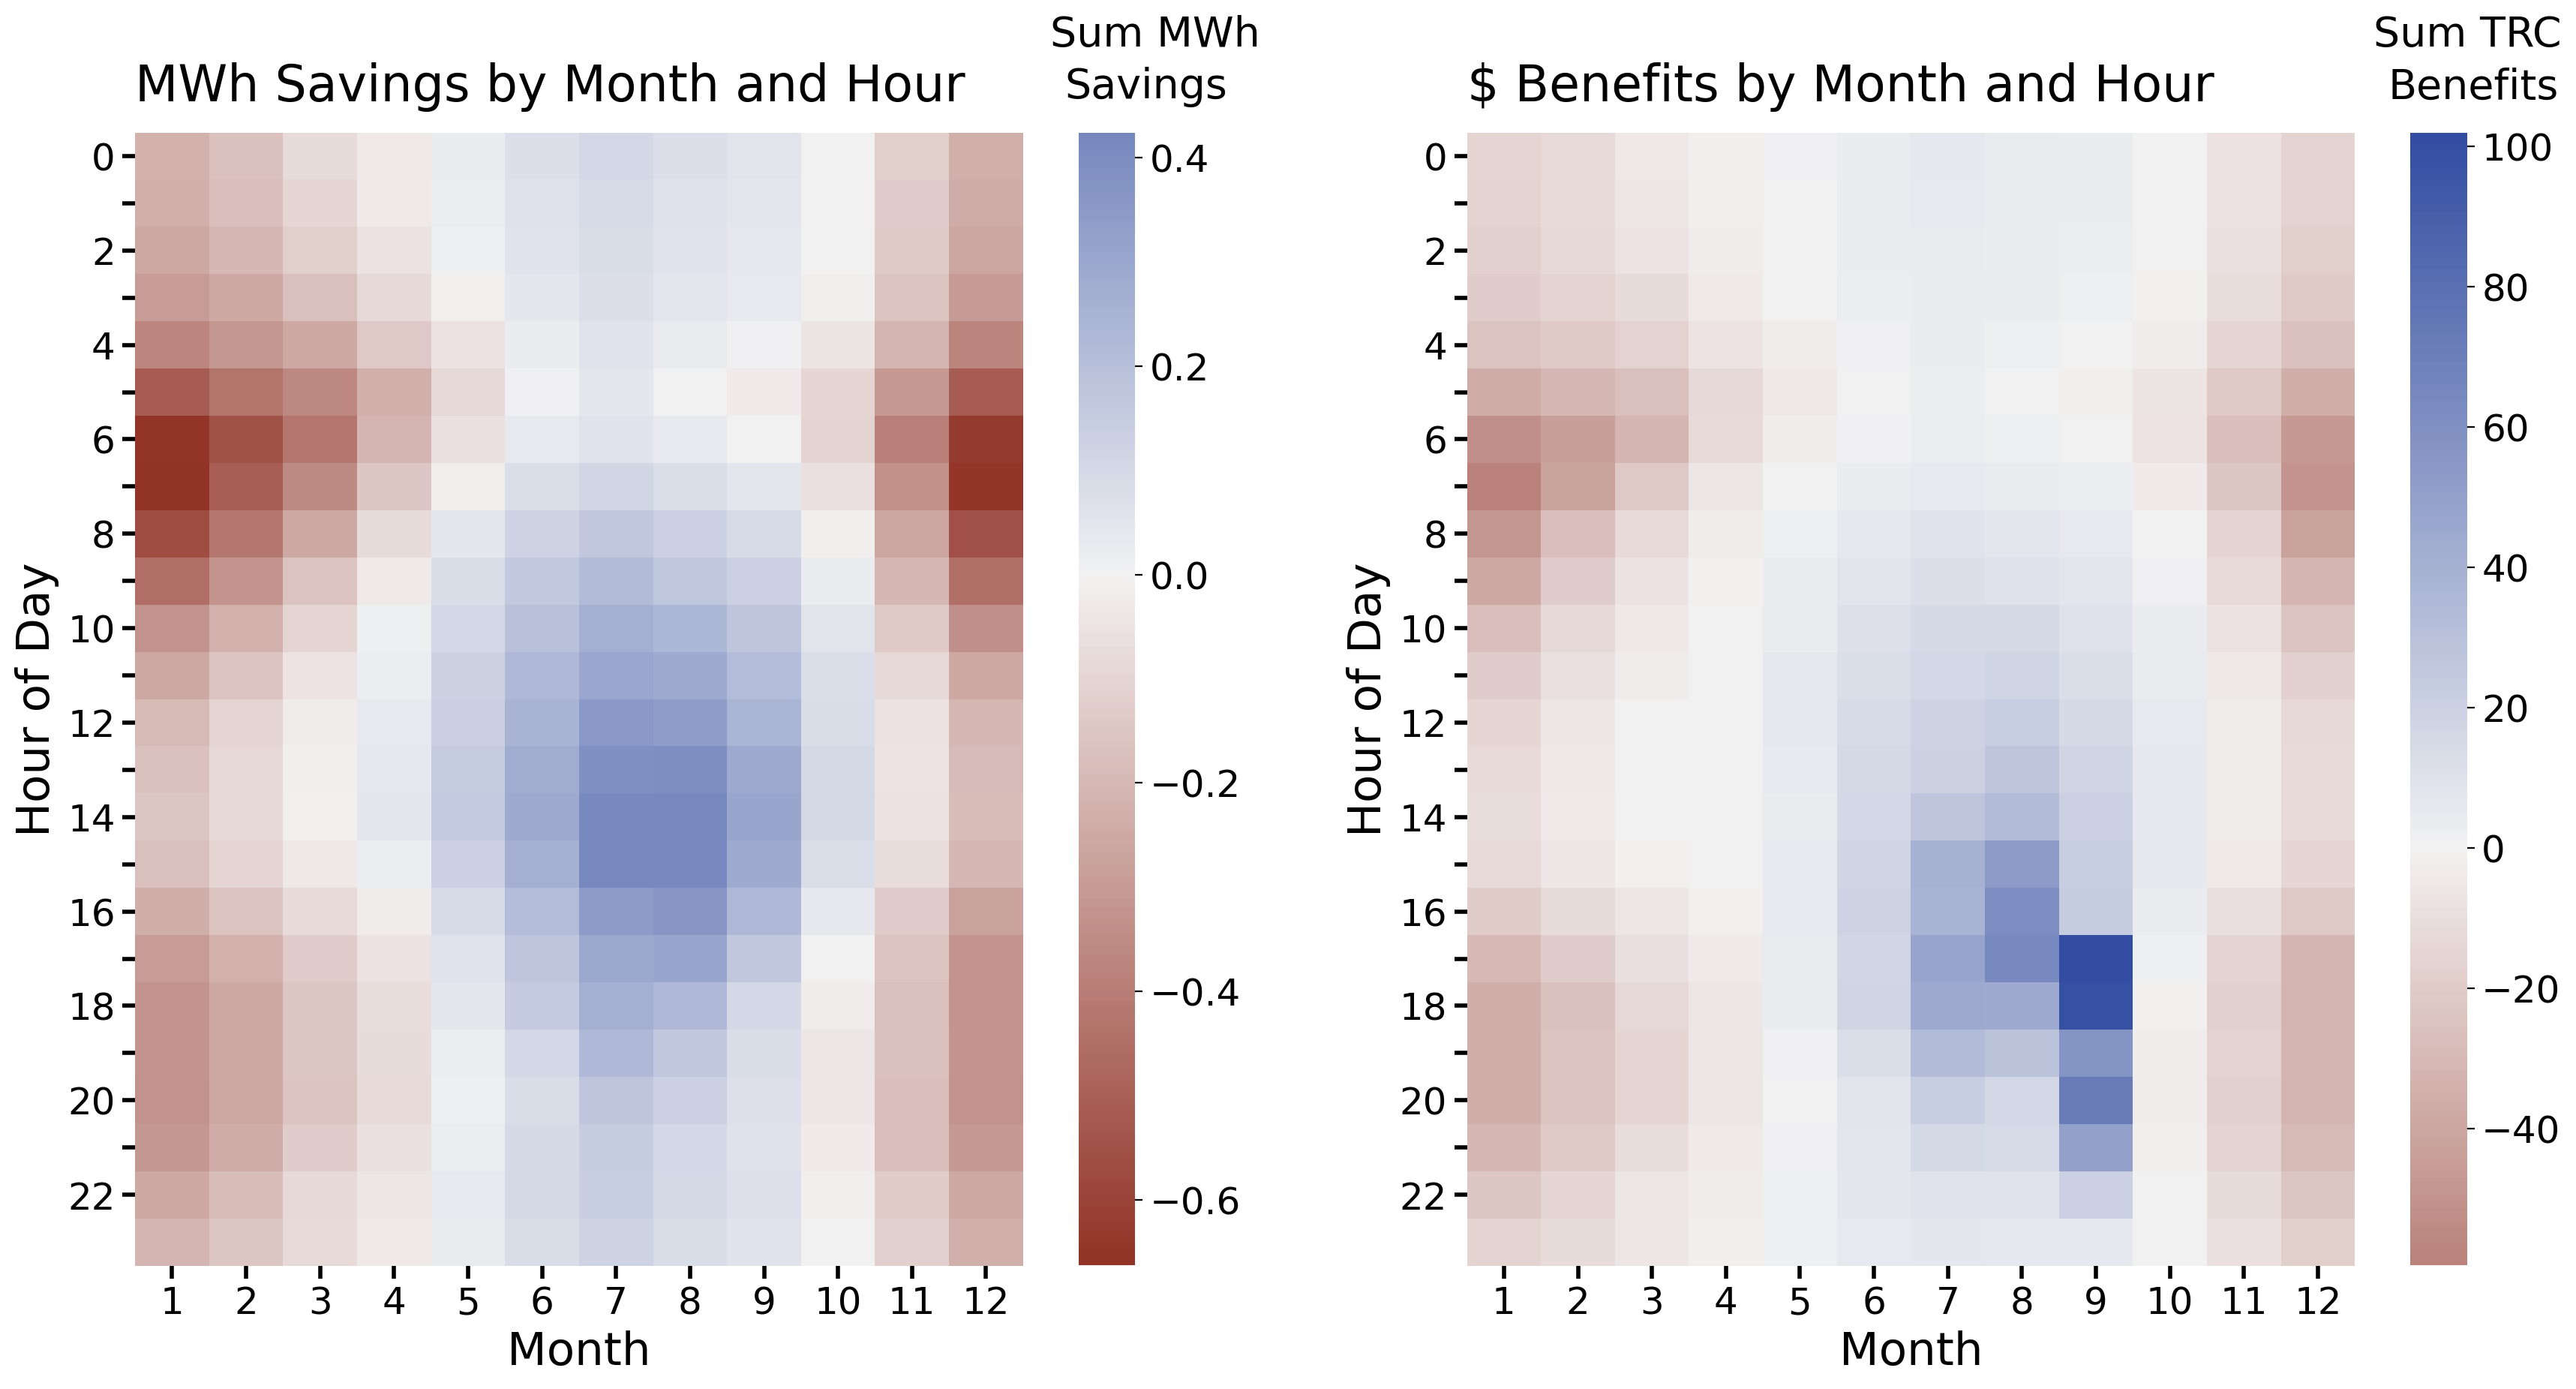

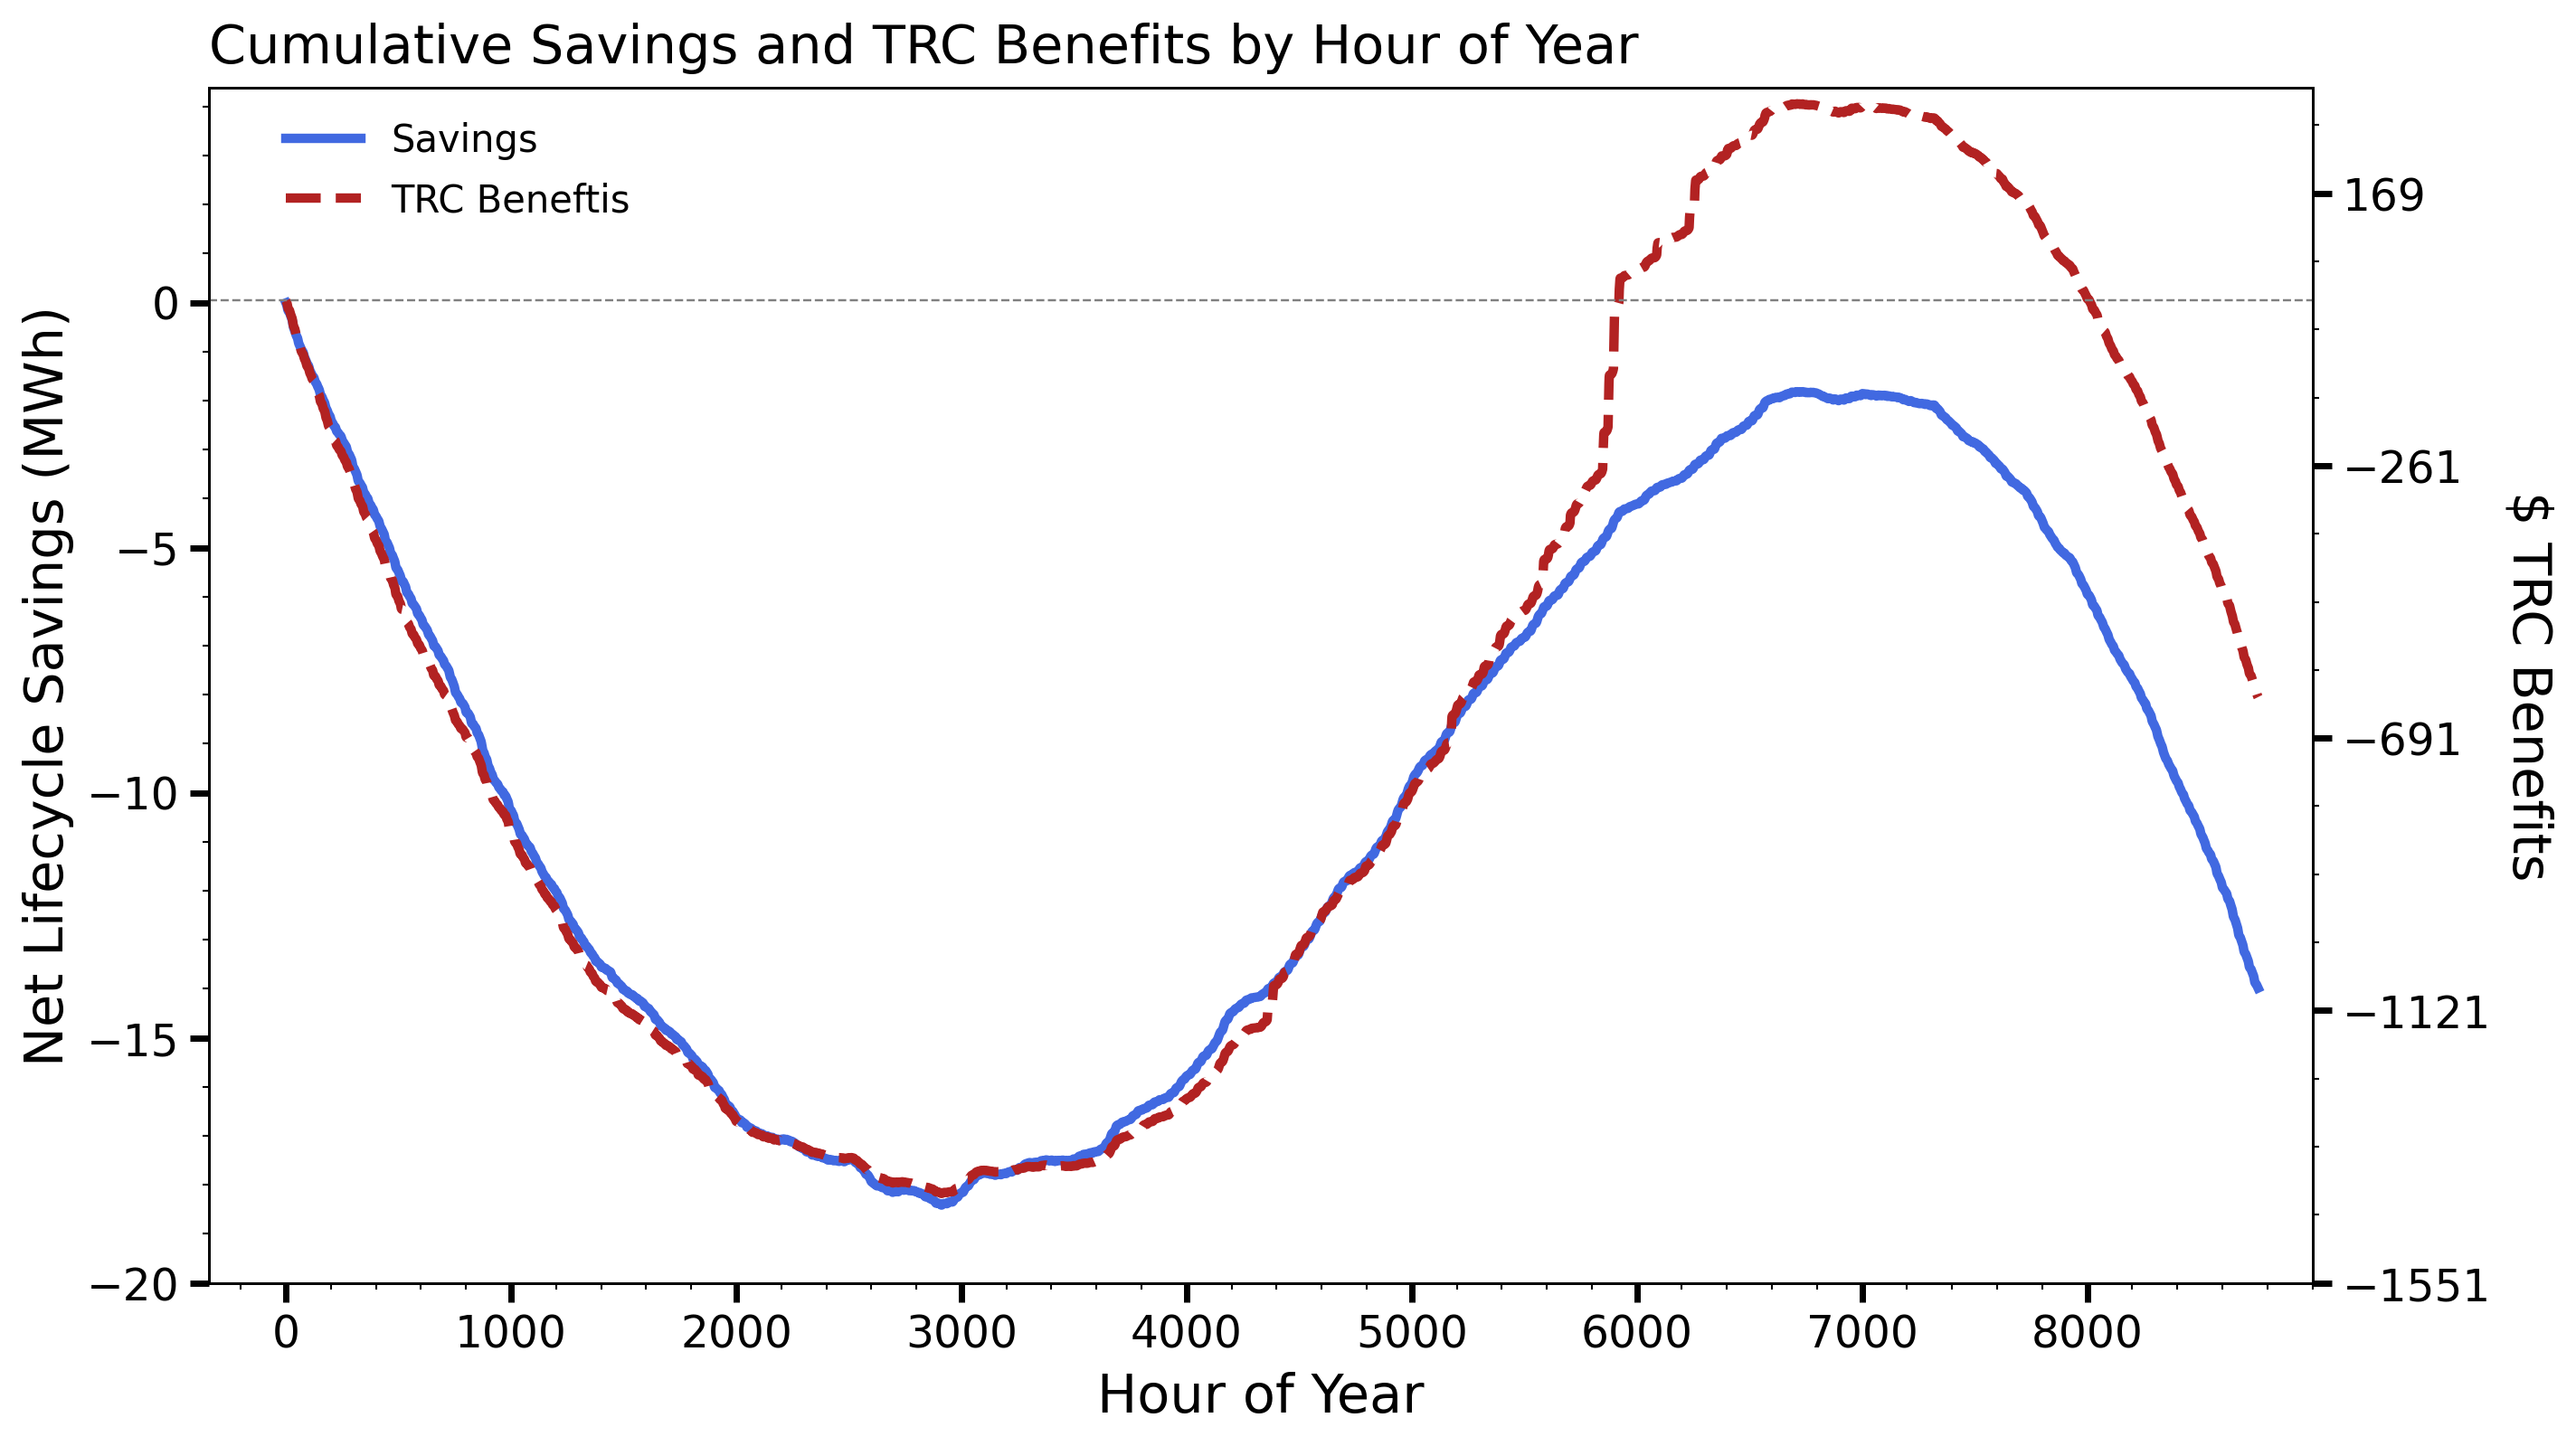

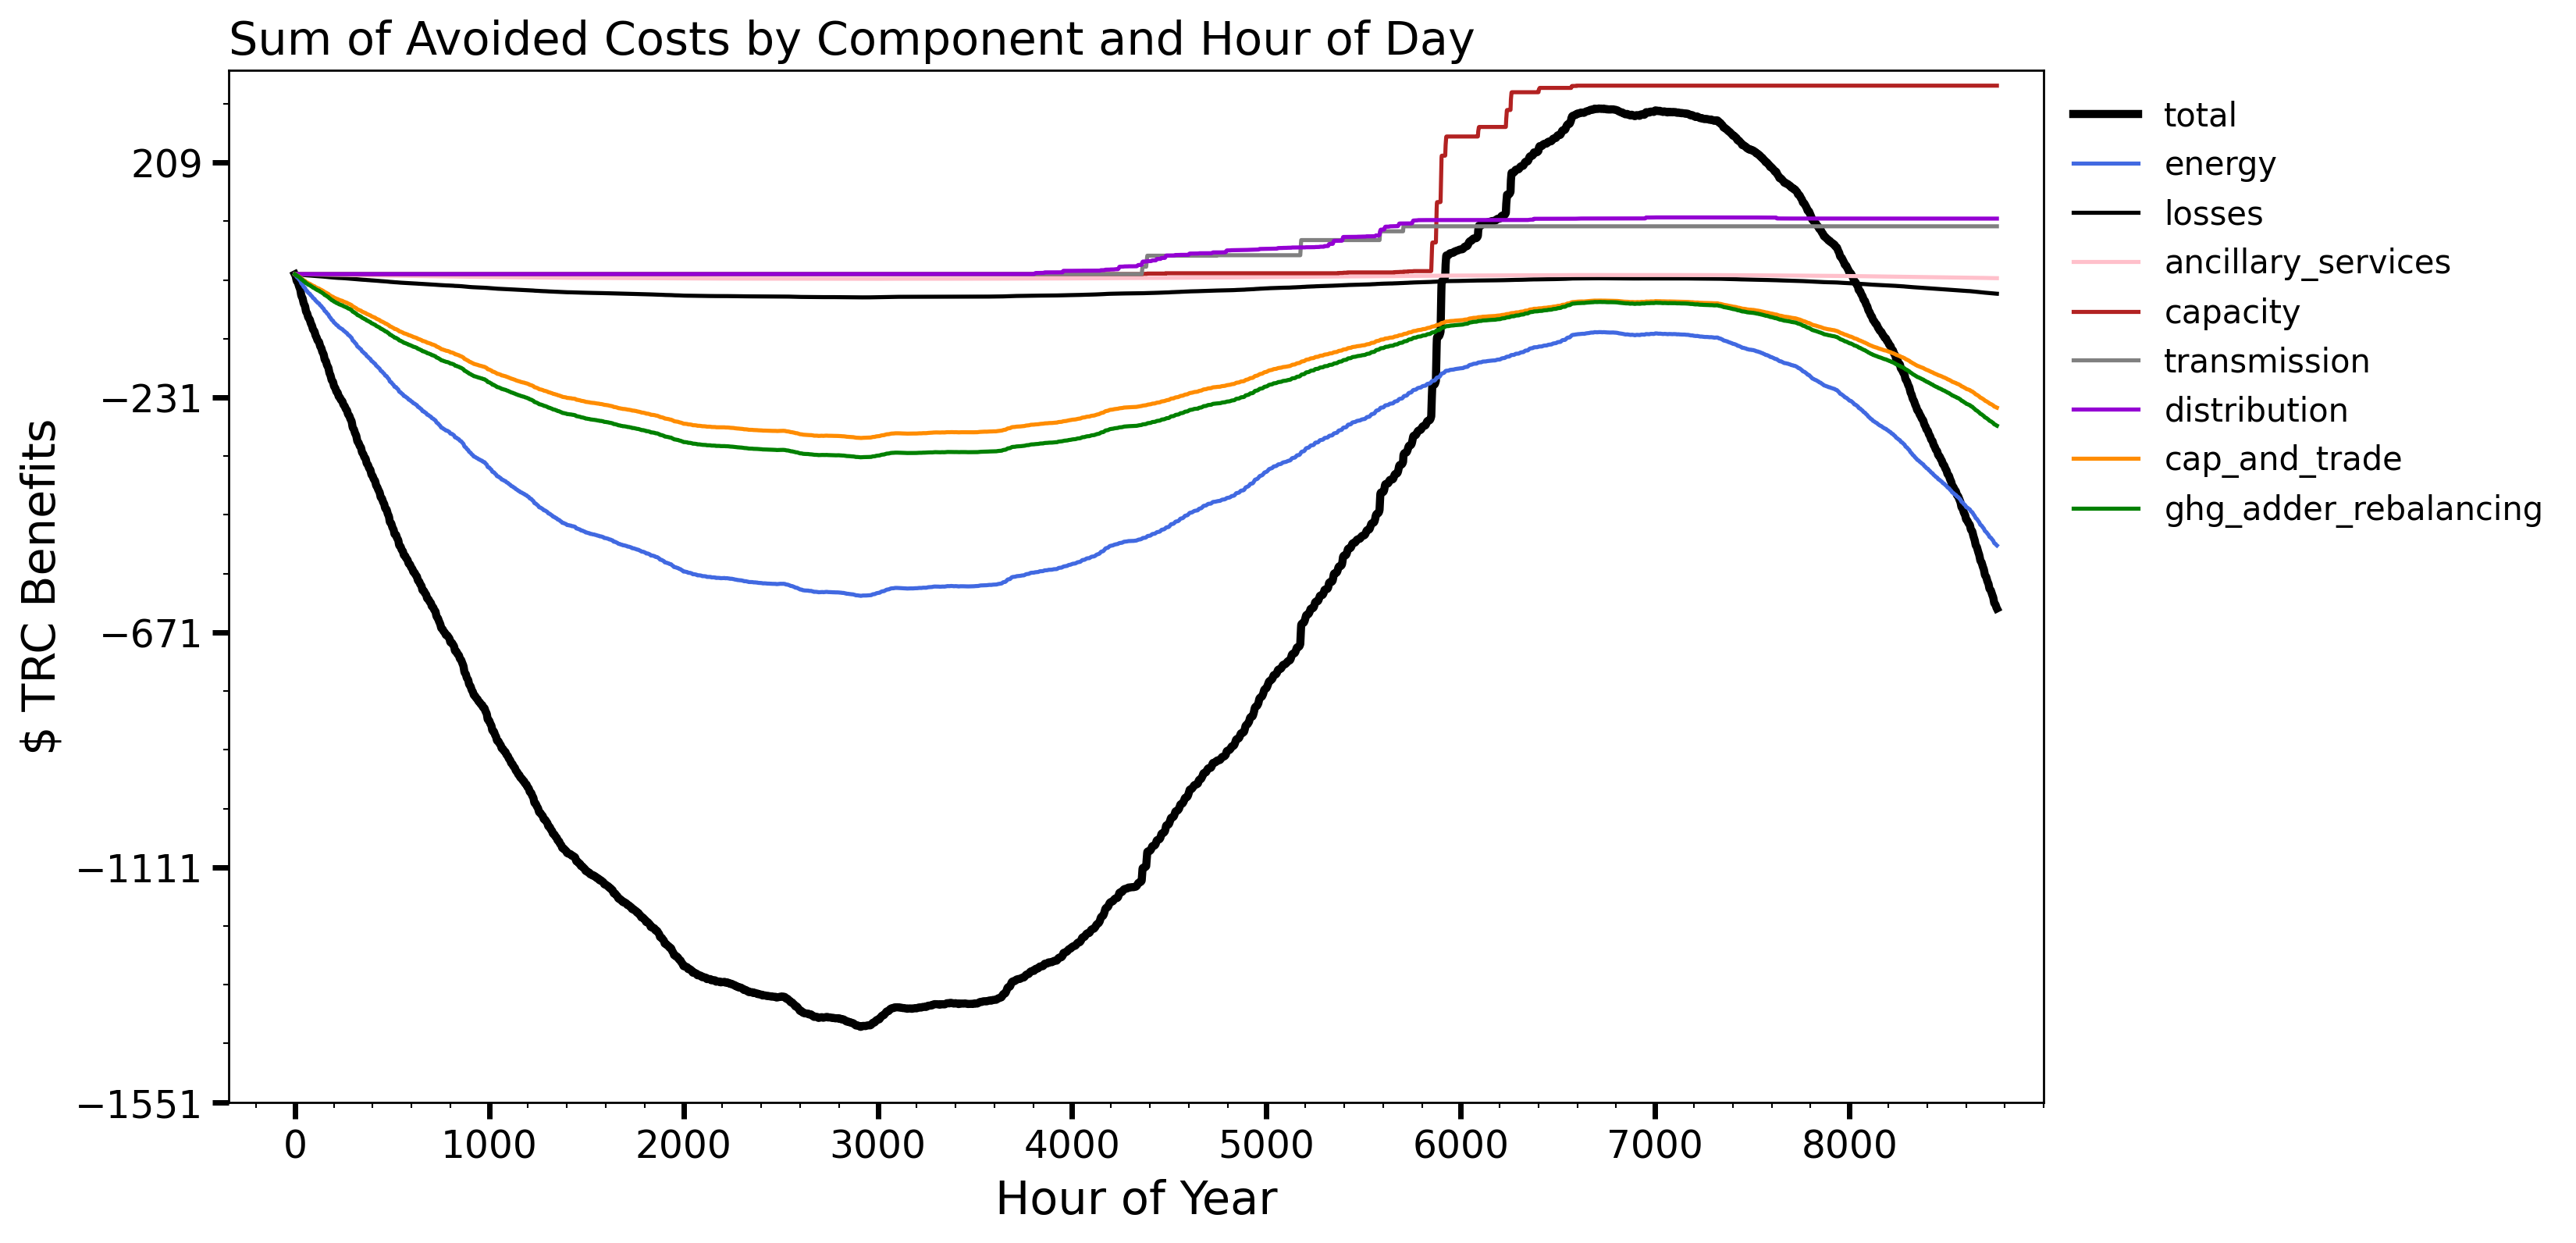

In [27]:
from flexvalue.plots import plot_results
plot_results(outputs_table_totals_metered, electric_benefits_metered, gas_benefits_metered)